# Part 3, Topic 1: AES256 Bootloader Attack (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *So far, we've been focusing on a single implementation of AES, TINYAES128C (or AVRCRYPTOLIB, if you're on XMEGA). TINYAES128C, which is designed to run on a variety of microcontrollers, doesn't make any implementation specific optimizations. In this lab, we'll look at how we can break a 32-bit optimized version of AES using a CPA attack.*

**LEARNING OUTCOMES:**

* Understanding how AES can be optimized on 32-bit platforms.
* Attacking an optimized version of AES using CPA

## The Situation

Simply put, we've got a target device running an encrypted bootloader (a program used to upload new code onto a device) and we want to see if we can get our own code running on the device. Let's say we've done the following background work:

* The device communicates over serial at 38400 baud
* When writing memory, the first byte is always zero (probably a command byte)
* There's a 16 byte block of random looking memory (aka it doesn't look like firmware). This part is probably encrypted
* There's a 4 byte CRC at the end of each message
* 

All together this looks like:

```
       |<-------- Encrypted block (16 bytes) ---------->|
       |                                                |
+------+------+------+------+------+------+ .... +------+------+------+
| 0x00 |              Random looking data               |   CRC-16    |
+------+------+------+------+------+------+ .... +------+------+------+
```

We'll also make our usual assumption of having something to trigger our capture off of.

## Doing Recon

Our first step will be to see if we can learning anything about the bootloader from looking at its power traces. Let's send a random message and record and plot one:

In [26]:
def cap_trace(enc_block):
    message = [0x00]
    target.read()

    key, text = ktp.next()
    message.extend(enc_block)

    crc = bl_crc.bit_by_bit(enc_block)
    message.append(crc >> 8)
    message.append(crc & 0xFF)

    scope.arm()

    target.write(message)


    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')
    response = target.read()
    if ord(response[0]) != 0xA4:
        # Bad response, just skip
        print("Bad response: {:02X}".format(ord(response[0])))
        return None

    return scope.get_last_trace()
    
ktp = cw.ktp.Basic()
text, key = ktp.next()
wave = cap_trace(text)

<IPython.core.display.Javascript object>


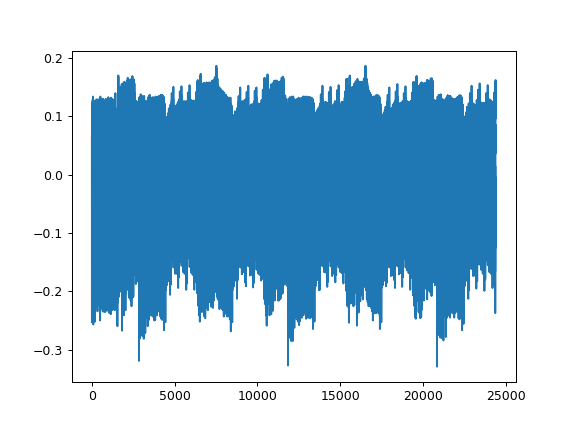

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

We can see some distinct repeated blocks, so this might be AES. One thing to notice: there's
no calculations going on at the beginning of the trace. We can't see the full encryption, so let's decimate the output and look again:

In [30]:
scope.adc.decimate = 4

<IPython.core.display.Javascript object>


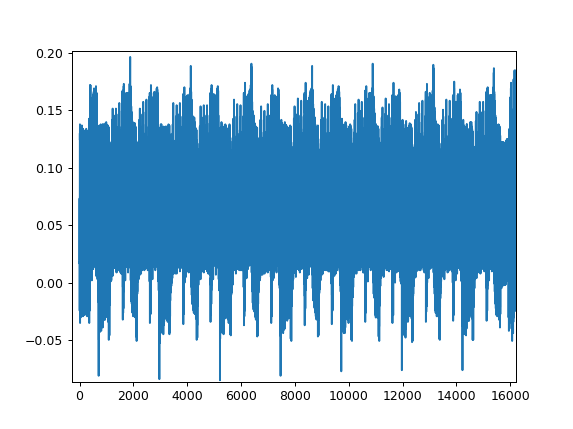

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(cap_trace(text))
plt.show()

There's 14 rounds - there's 14 rounds in AES256, so we'll make a guess and say that's what it's using for its cipher.

It's also clearly doing some extra stuff at the end - we're probably dealing with AES in a block cipher mode. This might make the attack pretty tricky depending on which one is used. For now, let's assume that what's being decrypted here is the cipher text and not some constant or counter.

## Attacking AES256

If it really is AES256, we can actually attack it pretty easily by adding a few extensions onto our standard AES128 CPA attack. You can read https://wiki.newae.com/Extending_AES-128_Attacks_to_AES-256 for the full details, but basically

1. Do a regular CPA attack on the first 16 key bytes at the input to the last round of encryption
1. Use the key we recovered to get the input to the last round
1. Do the same CPA attack across the second last round to recover the rest of the bytes.
     * There's a mix columns operation in the second last round, but it's a linear operation, meaning the correlation is unchanged. All this means is that we'll recover the key with Inv_Mix_Columns and Inv_Shift_Rows applied to it.

## Background

In the world of microcontrollers, a bootloader is a special piece of firmware that is made to let the user upload new programs into memory. This is especially useful for devices with complex code that may need to be patched or otherwise updated in the future - a bootloader makes it possible for the user to upload a patched version of the firmware onto the micro. The bootloader receives information from a communication line (a USB port, serial port, ethernet port, WiFi connection, etc...) and stores this data into program memory. Once the full firmware has been received, the micro can happily run its updated code.

There is one big security issue to worry about with bootloaders. A company may want to stop their customers from writing their own firmware and uploading it onto the micro. For example, this might be for protection reasons - hackers might be able to access parts of the device that weren't meant to be accessed. One way of stopping this is to add encryption. The company can add their own secret signature to the firmware code and encrypt it with a secret key. Then, the bootloader can decrypt the incoming firmware and confirm that the incoming firmware is correctly signed. Users will not know the secret key or the signature tied to the firmware, so they won't be able to "fake" their own.

This tutorial will work with a simple AES-256 bootloader. The victim will receive data through a serial connection, decrypt the command, and confirm that the included signature is correct. Then, it will only save the code into memory if the signature check succeeded. To make this system more robust against attacks, the bootloader will use cipher-block chaining (CBC mode). Our goal is to find the secret key and the CBC initialization vector so that we could successfully fake our own firmware.

## Bootloader Communications Protocol

The bootloader's communications protocol operates over a serial port at 38400 baud rate. The bootloader is always waiting for new data to be sent in this example; in real life one would typically force the bootloader to enter through a command sequence.

:

```
       |<-------- Encrypted block (16 bytes) ---------->|
       |                                                |
+------+------+------+------+------+------+ .... +------+------+------+
| 0x00 |    Signature (4 Bytes)    |  Data (12 Bytes)   |   CRC-16    |
+------+------+------+------+------+------+ .... +------+------+------+
```

This frame has four parts:

* `0x00`: 1 byte of fixed header
* Signature: A secret 4 byte constant. The bootloader will confirm that this signature is correct after decrypting the frame.
* Data: 12 bytes of the incoming firmware. This system forces us to send the code 12 bytes at a time; more complete bootloaders may allow longer variable-length frames.
* CRC-16: A 16-bit checksum using the CRC-CCITT polynomial (0x1021). The LSB of the CRC is sent first, followed by the MSB. The bootloader will reply over the serial port, describing whether or not this CRC check was valid.

As described in the diagram, the 16 byte block is not sent as plaintext. Instead, it is encrypted using AES-256 in CBC mode. This encryption method will be described in the next section.

The bootloader responds to each command with a single byte indicating if the CRC-16 was OK or not:

```
            +------+
CRC-OK:     | 0xA1 |
            +------+

            +------+
CRC Failed: | 0xA4 |
            +------+
```
Then, after replying to the command, the bootloader veries that the signature is correct. If it matches the expected manufacturer's signature, the 12 bytes of data will be written to flash memory. Otherwise, the data is discarded.

## Details of AES-256 CBC

The system uses the AES algorithm in Cipher Block Chaining (CBC) mode. In general one avoids using encryption 'as-is' (i.e. Electronic Code Book), since it means any piece of plaintext always maps to the same piece of ciphertext. Cipher Block Chaining ensures that if you encrypted the same thing a bunch of times it would always encrypt to a new piece of ciphertext.

You can see another reference on the design of the encryption side; we'll be only talking about the decryption side here. In this case AES-256 CBC mode is used as follows, where the details of the AES-256 Decryption block will be discussed in detail later:

![AES-256](https://wiki.newae.com/images/8/88/Aes256_cbc.png)

This diagram shows that the output of the decryption is no longer used directly as the plaintext. Instead, the output is XORed with a 16 byte mask, which is usually taken from the previous ciphertext. Also, the first decryption block has no previous ciphertext to use, so a secret initialization vector (IV) is used instead. If we are going to decrypt the entire ciphertext (including block 0) or correctly generate our own ciphertext, we'll need to find this IV along with the AES key.

### Attacking AES-256

The system in this tutorial uses AES-256 encryption, which has a 256 bit (32 byte) key - twice as large as the 16 byte key we've attacked in previous tutorials. This means that our regular AES-128 CPA attacks won't quite work. However, it's pretty straight forward to extend the attack because the first round of decryption uses the 1st 16 bytes, and the second round uses the last 16 bytes. This means we really just need to do the following:

1. Do a regular CPA attack on the first 16 key bytes at the input to the last round of encryption
1. Use the key we recovered to get the input to the last round
1. Do the same CPA attack across the second last round to recover the rest of the bytes.
     * There's a mix columns operation in the second last round, but it's a linear operation, meaning the correlation is unchanged. All this means is that we'll recover the key with Inv_Mix_Columns and Inv_Shift_Rows applied to it.

## Attacking AES-CBC

The fact that the bootloader is using CBC mode also introduces some additional complexity:

* This isn't an issue for this attack, but remember that we need to feed some known input into the AES algorithm. If this setup was revered - we were feeding in plaintext instead of ciphertext and the target was encrypting instead of decrypting - we wouldn't be able to do an attack without first learning the IV
* We'll need to learn the IV in some way to make the first plaintext block valid.

## CRC

The next step we'll need to take in attacking this target is to communicate with it. Most of the transmission is fairly straight forward, but the CRC is a little tricky. Luckily, there's a lot of open source out there for calculating CRCs. In this case, we'll pull some code from pycrc:

In [1]:
# Class Crc
#############################################################
# These CRC routines are copy-pasted from pycrc, which are:
# Copyright (c) 2006-2013 Thomas Pircher <tehpeh@gmx.net>
#
class Crc(object):
    """
    A base class for CRC routines.
    """

    def __init__(self, width, poly):
        """The Crc constructor.

        The parameters are as follows:
            width
            poly
            reflect_in
            xor_in
            reflect_out
            xor_out
        """
        self.Width = width
        self.Poly = poly


        self.MSB_Mask = 0x1 << (self.Width - 1)
        self.Mask = ((self.MSB_Mask - 1) << 1) | 1

        self.XorIn = 0x0000
        self.XorOut = 0x0000

        self.DirectInit = self.XorIn
        self.NonDirectInit = self.__get_nondirect_init(self.XorIn)
        if self.Width < 8:
            self.CrcShift = 8 - self.Width
        else:
            self.CrcShift = 0

    def __get_nondirect_init(self, init):
        """
        return the non-direct init if the direct algorithm has been selected.
        """
        crc = init
        for i in range(self.Width):
            bit = crc & 0x01
            if bit:
                crc ^= self.Poly
            crc >>= 1
            if bit:
                crc |= self.MSB_Mask
        return crc & self.Mask


    def bit_by_bit(self, in_data):
        """
        Classic simple and slow CRC implementation.  This function iterates bit
        by bit over the augmented input message and returns the calculated CRC
        value at the end.
        """
        # If the input data is a string, convert to bytes.
        if isinstance(in_data, str):
            in_data = [ord(c) for c in in_data]

        register = self.NonDirectInit
        for octet in in_data:
            for i in range(8):
                topbit = register & self.MSB_Mask
                register = ((register << 1) & self.Mask) | ((octet >> (7 - i)) & 0x01)
                if topbit:
                    register ^= self.Poly

        for i in range(self.Width):
            topbit = register & self.MSB_Mask
            register = ((register << 1) & self.Mask)
            if topbit:
                register ^= self.Poly

        return register ^ self.XorOut
    
bl_crc = Crc(width = 16, poly=0x1021)

Now we can easily get the CRC for our message by calling `bl_crc.bit_by_bit(message)`. 

## Communicating with the Bootloader

With that done, we can start communicating with the bootloader. Recall that the bootloader expects:

* To start with `0x00`
* A 16 byte encrypted message (4 bytes signature + 12 bytes data)
* CRC16

We don't really care what the 16 byte message is (just that each is different so that we get a variety of Hamming weights), so we'll use the same text/key module from earlier attacks.

We can now run the following block, and we should get `0xA4` back. You may need to run this block a few times to get the right response back.

In [5]:
import time
okay = 0
reset_target(scope)

while not okay:
    target.write('\0xxxxxxxxxxxxxxxxxx')
    time.sleep(0.05)
    response = target.read()
    if response:
        print(response)
        if ord(response[0]) == 0xA1:
            okay = 1

 
¡¡


In [6]:
import time
message = [0x00]
ktp = cw.ktp.Basic()

# clear serial buffer
print(target.read())

key, text = ktp.next() #don't care about key here
message.extend(text)

crc = bl_crc.bit_by_bit(text)

message.append(crc >> 8)
message.append(crc & 0xFF)

target.write(message)
time.sleep(0.1)

response = target.read()
print("Response: {:02X}".format(ord(response[0])))


Response: A4


In [3]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'

In [4]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [8]:
fw_path = "../../../hardware/victims/firmware/bootloader-aes256/bootloader-aes256-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5863 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5863 bytes
Serial baud rate = 38400


## Capturing Traces

With that out of the way, we can proceed to capturing our traces. The normal 5000 traces we capture isn't long enough to get the rounds we care about, so we'll need to increase it (15000 should be fine):

In [14]:
scope.adc.samples = 24400

We'll be working with Analyzer, so we'll need to use a ChipWhisperer project to store our traces and text:

In [10]:
project = cw.create_project("projects/Tutorial_A5", overwrite=True)
ktp = cw.ktp.Basic()

Construct your capture loop:

In [21]:
message = [0x00]
target.read()

key, text = ktp.next()
message.extend(text)

crc = bl_crc.bit_by_bit(text)
message.append(crc >> 8)
message.append(crc & 0xFF)

scope.arm()

target.write(message)

ret = scope.capture()
if ret:
    print('Timeout happened during acquisition')
response = target.read()
if ord(response[0]) != 0xA4:
    # Bad response, just skip
    print("Bad response: {:02X}".format(ord(response[0])))

wave = scope.get_last_trace()

In [17]:
scope.adc.decimate = 4

<IPython.core.display.Javascript object>


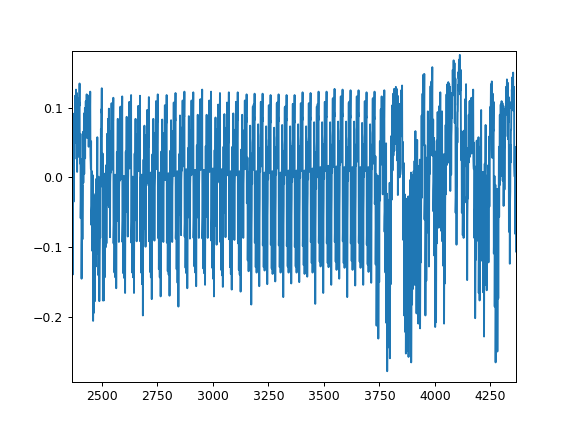

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

In [20]:
scope.adc.decimate = 1
scope.adc.offset = 15000*4

In [ ]:
#Capture Traces
# let's get them to do this
from tqdm import tnrange
import numpy as np
import time
N = 200  # Number of traces
for i in tnrange(N, desc='Capturing traces'):
    message = [0x00]
    target.read()
    
    key, text = ktp.next()
    message.extend(text)
    
    crc = bl_crc.bit_by_bit(text)
    message.append(crc >> 8)
    message.append(crc & 0xFF)

    scope.arm()

    target.write(message)
    
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')
    response = target.read()
    if ord(response[0]) != 0xA4:
        # Bad response, just skip
        print("Bad response: {:02X}".format(ord(response[0])))
        continue
    
    project.traces.append(cw.Trace(scope.get_last_trace(), text, "", key))

## Analysis

Now that we have our traces, we can go ahead and perform the attack. As described in the background theory, we'll have to do two attacks - one to get the 14th round key, and another (using the first result) to get the 13th round key. Then, we'll do some post-processing to finally get the 256 bit encryption key.

### 14th Round Key

We can attack the 14th round key with a standard, no-frills CPA attack (using the inverse sbox, since it's a decryption that we're breaking):

In [ ]:
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa

leak_model = cwa.leakage_models.inverse_sbox_output

attack = cwa.cpa(project, leak_model)

With the setup done, we can actually preform the attack. Narrow the range of the attack if you want it to run faster.

In [ ]:
key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71, 0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51, 0x85, 0xc1, 0x3b, 0xcb]

cb = cwa.get_jupyter_callback(attack)
if PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
    attack.point_range = [1400, 2600]
elif PLATFORM == "CWLITEXMEGA" or PLATFORM == "CW303":
    pass
attack_results = attack.run(cb)

In [ ]:
rec_key = []
for bnum in attack_results.find_maximums():
    rec_key.append(bnum[0][0])
    print("Best Guess = 0x{:02X}, Corr = {}".format(bnum[0][0], bnum[0][2]))

### 13th Round Key

Analyzer doesn't have a leakage model for the 13th round key built in, so we'll need to create our own.

The traces for the XMEGA version of the firmware become desynced around sample 7000. This is due to a non-constant AES implementation: the code does not always take the same amount of time to run for every input. (It's actually possible to do a timing attack on this AES implementation! We'll stick with our CPA attack for now.)

While this does open up a timing attack, it actually makes our AES attack a little harder, since we'll have to resync the traces. Luckily you already know how to resync the traces!

Remember, what you're recovering here isn't actually the 13th round key since there was a mix columns operation in that round. Instead, what we've recovered is:

```python
InvShiftRows(InvMixColumns(recv_key))
```

Undo these operations and you should arrive at the correct 13th round key!

### Getting the First Round Key

We've got our AES256 decryption key now, but we can't use that to encrypt the plaintext, only decrypt. We'll need to use those to calculate the first and second round keys, which we can then use to encrypt the plaintext. ChipWhisperer has a built in function for doing the key schedule calculation:

With that, we're ready to move onto breaking the rest of the bootloader (the IV and signature). Let's start off by doing a little recon. 